In [1]:
import os
import pandas as pd
import numpy as np




# Read all into a df

In [2]:
#FILE FORMAT: 
#PERSON IS THE DIRECTORY NAME 
#Action_take

def read_data(file_path,file_name, dirr):
    
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    
    action = file_name.split("_")[0].lower()  
    
    file_end = action.split(".")
    if len(file_end) > 1: 
        if file_end[1] == 'txt': 
            action = file_end[0]
    if action == 'hammer':
        action = 'thor'
    if action == 'portal':
        action = 'strange'
    if action == 'stange': 
        action = 'strange'
    if action == 'web': 
        action = 'spider'
    if action == 'logout': 
        action = 'end'
    if action == 'nothing': 
        action = 'random'
    person = dirr.split("_")[0]
    
    data = {'action': action, 
            'person': person}
    
    data = []
    
    if action not in action_count: 
        action_count[action] = 0
    
    count = 0
    action_data = []
    #print(data)
    for line in lines:
        if line.isspace(): 
            continue
        if not line[0].isdigit():
            continue
        line = line.strip()
        index = int(line.split(" ")[0])
        line_data = line.split("(")[1]
        line_data = line_data.split(")")[0]
        line_data = line_data.split(", ")[2:10]
            
        line_data = [int(x) for x in line_data]
        if index == 0: 
            action_count[action] += 1
        action_data.append([action, action_count[action], person, index] + line_data)

    df = pd.DataFrame(action_data, columns=[ "action", "reading_num", "person" , 'index','gyro_x', 'gyro_y', 'gyro_z', 'acc_x', 'acc_y', 'acc_z',  'flex1', 'flex2'])
    return df

In [3]:
path = "./cleaned_data"

action_count = {}

In [6]:
action_count

{'grenade': 876,
 'shield': 1020,
 'spider': 1584,
 'thor': 1242,
 'end': 956,
 'left': 457,
 'punch': 1393,
 'random': 2579,
 'reload': 1162,
 'right': 440,
 'spear': 918,
 'strange': 944}

In [5]:
df = pd.DataFrame()
for root, dirs, files in os.walk(path):
    for dirr in dirs:
        files = os.listdir(os.path.join(root, dirr))        
        print(dirr)   
        for file in files: 
            
            file_path = os.path.join(root, dirr, file)
            
            df_temp = read_data(file_path, file, dirr)
            
            df = df.append(df_temp, ignore_index = True)
            

Abhinav_Data
Archit_Data
Arushi_Data
Beatrice_Data
BoTuan_Data
ChinHan_Data
combined_Data
David_Data
Group3_Data
Ivan_Data
Jerone_Data
Jill_Data
Jovann_Data
KahHeng_Data
Kunal_Data
Marcus_Data
Nandini_Data
Prachi_Data
Rachel_Data
Subhan_Data
swann_Data
Vanshika_Data
Wilson_Data
Yi Zhi_Data
YiJie_Data
ZhuZiKun_Data
zihan_Data
ZiKun_Data


In [7]:
df.head()

,action,reading_num,person,index,gyro_x,gyro_y,gyro_z,acc_x,acc_y,acc_z,flex1,flex2
0,grenade,1,Abhinav,0,0,0,0,0,0,4,2,2
1,grenade,1,Abhinav,1,41,0,0,0,0,25,2,2
2,grenade,1,Abhinav,2,216,9,0,0,0,0,2,2
3,grenade,1,Abhinav,3,446,144,0,0,0,0,2,2
4,grenade,1,Abhinav,4,566,259,0,0,0,0,2,2


In [7]:
#save as a csv 
df.to_csv("data.csv", index = False)

# Start Data Processing for Train_Val and Test


In [8]:
df = pd.read_csv("data.csv")
df.drop(columns = ['person'], inplace = True)

In [9]:
actions = ["strange", "spider", "shield", "thor", "grenade", "spear", "reload", "punch",  'end', "random"]

In [10]:
y = []
X = []

for action in actions: 
    actions_df = df[df['action']==action].copy().drop(columns = 'action')
    readings = actions_df['reading_num'].unique()
    
    for reading in readings:
        y.append(actions.index(action))
        X.append(actions_df[actions_df['reading_num'] == reading].iloc[:,-8:].values.tolist())

In [50]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=43)

In [41]:
with open('val_values.py', 'w') as file:
    file.write("y = ")
    file.write(", ".join(map(str, y_val)))
    
    file.write("\n\n")
    
    file.write("X = ")
    file.write(", ".join(map(str, X_val)))

In [42]:
len(X_val)

1190

# Preprocess


In [51]:
from numpy.fft import fft, ifft

def fft_funct(x, n): 
    Ts = 0.05
    Sr = 1/Ts
    
    t = np.arange(0,(n)*Ts, Ts)
    
    X = fft(x)
    N = len(X)
    
    n = np.arange(N)
    T = N/Sr
    freq = n/T
    
    return np.abs(X)

In [52]:
def preprocess(reading): 
    #insert means
    data = []
    temp = np.zeros((12,30))
    if len(reading) < 8*30:         
        num_readings = int(len(reading)/8)
        
        reading = reading.reshape((num_readings, 8))
        
        column_means = np.mean(reading, axis=0)
        new_row = np.array([column_means]).astype(int)
        for i in range(len(reading), 30):
            reading = np.vstack((reading, new_row))
        reading = reading.flatten()
        
    #get the first 30 readings
    reading = reading[0:8*30]
    
    count = 0
    for i in range(30):
        for j in range(8):
            temp[j][i] = reading[count]
            count += 1
            
    for j in range(6):
        data.extend(temp[j])
    for j in range(6):
        data.extend(fft_funct(temp[j], 16))
    
    return np.array(data).reshape(12,30)

In [53]:
#get means and stds for each col
for i in range(len(X_train)):
    X_train[i] = preprocess(np.array(X_train[i]).flatten())
    
X_train_np = np.array(X_train)

means = np.mean(X_train_np, axis = (0,2))
stds = np.std(X_train_np, axis = (0,2))

In [54]:
means

array([109.8709948 , 111.73000468, 116.47304635,  12.29022152,
        20.54313519,  40.58658308, 765.7583228 , 781.76443787,
       817.89366553,  87.27934185, 197.37043285, 216.14098239])

In [55]:
len(X_val)

1268

In [56]:
# Write the array to a text file
with open('standardisations_15nov_3.py', 'w') as file:
    file.write("means = [")
    file.write(", ".join(map(str,means)))
    file.write("]")
    
    file.write("\n\n")
    
    file.write("stds = [")
    file.write(", ".join(map(str,stds)))
    file.write("]")

In [57]:
def standardise(reading):
    for i in range(30): 
        for j in range(12): 
            reading[j][i] = (reading[j][i] - means[j])/stds[j]
    reading = reading.reshape(12,30,1).tolist()
    return reading

In [58]:
for i in range(len(X_train)):
    X_train[i] = standardise(X_train[i])

for i in range(len(X_val)):
    temp = preprocess(np.array(X_val[i]).flatten())
    X_val[i] = standardise(temp)

In [59]:
X_val_np = np.array(X_val).flatten().reshape(len(X_val),12,30).tolist()

In [65]:
len(X_val) 


1190

In [60]:
size = len(X_val)

# Write the array to a C++ header file
with open('test_values_15nov_3.h', 'w') as file:
    array_name = 'test_results'
    file.write(f"int {array_name}[{size}] = {{")
    for elem in y_val:
        file.write(f"{elem}, ")
    file.write("};\n")
    
    
    array_name = 'test_values'
    file.write(f"float {array_name}[{size}][14][30] = {{\n")
    for d in range(size):
        file.write(f"  {{\n")
        for r in range(12):
            file.write(f"    {{")
            for c in range(30):
                file.write(f"{X_val_np[d][r][c]}, ")
            file.write(f"}},\n")
        file.write(f"  }},\n")
    file.write(f"}};")


# Train Model


In [61]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, AveragePooling2D, Conv1D
from tensorflow.keras.callbacks import ModelCheckpoint

In [62]:
readings = 30
sensors = 12
channels = 1
num_classes = 10


model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(sensors ,readings,  1)),  # Convolutional layer with 32 filters, 3x3 kernel, and ReLU activation
    MaxPooling2D((2, 2)),
    
    #AveragePooling2D((2, 2)),  # MaxPooling layer with 2x2 pool size
    Flatten(),  # Flatten layer to transition from convolutional layers to dense layers
    Dropout(0.2),
    Dense(64, activation='relu'),  # Dense layer with 64 units and ReLU activation
    Dropout(0.2),
    Dense(32, activation='relu'),  # Dense layer with 64 units and ReLU activation
    Dropout (0.1),
#     Dense(16, activation='relu'),  # Dense layer with 64 units and ReLU activation
#     Dropout (0.2),
    Dense(num_classes, activation='softmax')  # Output layer with softmax activation (adjust num_classes)
])

In [63]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print a summary of the model architecture
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 10, 28, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 14, 32)        0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 2240)              0         
                                                                 
 dropout_9 (Dropout)         (None, 2240)              0         
                                                                 
 dense_9 (Dense)             (None, 64)                143424    
                                                                 
 dropout_10 (Dropout)        (None, 64)                0         
                                                      

In [64]:
    #class_names = {"Strange":0, "Spider":1, "Shield":2, "Thor":3, "Grenade":4, 
    #               "Spear":5, "Reload":6, "Punch":7,  'End':8, "Random":9}
class_weight = {0: 1.4,
                1: 1.5,
                2: 1., 
               3: 1.8,
               4: 1.,
               5:1., 
               6: 1.,
               7: 1.,
               8: 1.,
               9: 1.}

In [65]:
# Create a ModelCheckpoint callback
checkpoint_filepath = 'model_15nov_3.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,  # Save only the model weights
    monitor='val_accuracy',  # Choose a metric to monitor (e.g., validation loss)
    save_best_only=True,  # Save only the best model
    verbose=1, # Display a message when saving
)

In [66]:
len(X_val)

1268

In [67]:
X_train = np.array(X_train)
X_val = np.array(X_val)
y_train = np.array(y_train)
y_val = np.array(y_val)

In [68]:
# Train your model and use the ModelCheckpoint callback
epochs = 100
batch_size = 32

history_cnn = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    callbacks=[model_checkpoint_callback], 
    class_weight = class_weight
)

Epoch 1/100
354/357 [============================>.] - ETA: 0s - loss: 1.6159 - accuracy: 0.5195
Epoch 1: val_accuracy improved from -inf to 0.72713, saving model to model_15nov_3.h5
357/357 [==============================] - 4s 9ms/step - loss: 1.6132 - accuracy: 0.5205 - val_loss: 0.8527 - val_accuracy: 0.7271
Epoch 2/100
353/357 [============================>.] - ETA: 0s - loss: 1.0402 - accuracy: 0.7131
Epoch 2: val_accuracy improved from 0.72713 to 0.79338, saving model to model_15nov_3.h5
357/357 [==============================] - 3s 9ms/step - loss: 1.0408 - accuracy: 0.7132 - val_loss: 0.6599 - val_accuracy: 0.7934
Epoch 3/100
353/357 [============================>.] - ETA: 0s - loss: 0.8886 - accuracy: 0.7601
Epoch 3: val_accuracy improved from 0.79338 to 0.82256, saving model to model_15nov_3.h5
357/357 [==============================] - 4s 10ms/step - loss: 0.8877 - accuracy: 0.7603 - val_loss: 0.5680 - val_accuracy: 0.8226
Epoch 4/100
353/357 [============================>.

Epoch 29/100
354/357 [============================>.] - ETA: 0s - loss: 0.3662 - accuracy: 0.8962
Epoch 29: val_accuracy did not improve from 0.87461
357/357 [==============================] - 4s 10ms/step - loss: 0.3661 - accuracy: 0.8962 - val_loss: 0.4543 - val_accuracy: 0.8746
Epoch 30/100
353/357 [============================>.] - ETA: 0s - loss: 0.3628 - accuracy: 0.8965
Epoch 30: val_accuracy did not improve from 0.87461
357/357 [==============================] - 4s 10ms/step - loss: 0.3623 - accuracy: 0.8966 - val_loss: 0.4941 - val_accuracy: 0.8565
Epoch 31/100
353/357 [============================>.] - ETA: 0s - loss: 0.3665 - accuracy: 0.8948
Epoch 31: val_accuracy did not improve from 0.87461
357/357 [==============================] - 3s 9ms/step - loss: 0.3666 - accuracy: 0.8945 - val_loss: 0.4504 - val_accuracy: 0.8644
Epoch 32/100
355/357 [============================>.] - ETA: 0s - loss: 0.3568 - accuracy: 0.8976
Epoch 32: val_accuracy did not improve from 0.87461
357/3

Epoch 58/100
357/357 [==============================] - ETA: 0s - loss: 0.2847 - accuracy: 0.9179
Epoch 58: val_accuracy did not improve from 0.88091
357/357 [==============================] - 3s 9ms/step - loss: 0.2847 - accuracy: 0.9179 - val_loss: 0.5016 - val_accuracy: 0.8738
Epoch 59/100
356/357 [============================>.] - ETA: 0s - loss: 0.2679 - accuracy: 0.9192
Epoch 59: val_accuracy did not improve from 0.88091
357/357 [==============================] - 3s 9ms/step - loss: 0.2683 - accuracy: 0.9191 - val_loss: 0.5041 - val_accuracy: 0.8746
Epoch 60/100
355/357 [============================>.] - ETA: 0s - loss: 0.2694 - accuracy: 0.9196
Epoch 60: val_accuracy did not improve from 0.88091
357/357 [==============================] - 4s 10ms/step - loss: 0.2692 - accuracy: 0.9196 - val_loss: 0.5400 - val_accuracy: 0.8659
Epoch 61/100
356/357 [============================>.] - ETA: 0s - loss: 0.2570 - accuracy: 0.9239
Epoch 61: val_accuracy did not improve from 0.88091
357/35

355/357 [============================>.] - ETA: 0s - loss: 0.2200 - accuracy: 0.9352
Epoch 87: val_accuracy did not improve from 0.88091
357/357 [==============================] - 3s 8ms/step - loss: 0.2194 - accuracy: 0.9355 - val_loss: 0.5458 - val_accuracy: 0.8762
Epoch 88/100
351/357 [============================>.] - ETA: 0s - loss: 0.2093 - accuracy: 0.9355
Epoch 88: val_accuracy did not improve from 0.88091
357/357 [==============================] - 3s 9ms/step - loss: 0.2123 - accuracy: 0.9348 - val_loss: 0.5937 - val_accuracy: 0.8580
Epoch 89/100
353/357 [============================>.] - ETA: 0s - loss: 0.2082 - accuracy: 0.9340
Epoch 89: val_accuracy did not improve from 0.88091
357/357 [==============================] - 3s 8ms/step - loss: 0.2104 - accuracy: 0.9335 - val_loss: 0.5634 - val_accuracy: 0.8793
Epoch 90/100
356/357 [============================>.] - ETA: 0s - loss: 0.2043 - accuracy: 0.9401
Epoch 90: val_accuracy did not improve from 0.88091
357/357 [===========

In [69]:
# Train your model and use the ModelCheckpoint callback
epochs = 100
batch_size = 32

history_cnn = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    callbacks=[model_checkpoint_callback], 
    #class_weight = class_weight
)

Epoch 1/100
356/357 [============================>.] - ETA: 0s - loss: 0.1599 - accuracy: 0.9424
Epoch 1: val_accuracy did not improve from 0.88091
357/357 [==============================] - 3s 9ms/step - loss: 0.1599 - accuracy: 0.9425 - val_loss: 0.5618 - val_accuracy: 0.8722
Epoch 2/100
352/357 [============================>.] - ETA: 0s - loss: 0.1767 - accuracy: 0.9367
Epoch 2: val_accuracy did not improve from 0.88091
357/357 [==============================] - 4s 10ms/step - loss: 0.1771 - accuracy: 0.9367 - val_loss: 0.5790 - val_accuracy: 0.8730
Epoch 3/100
355/357 [============================>.] - ETA: 0s - loss: 0.1773 - accuracy: 0.9395
Epoch 3: val_accuracy did not improve from 0.88091
357/357 [==============================] - 3s 9ms/step - loss: 0.1766 - accuracy: 0.9398 - val_loss: 0.5429 - val_accuracy: 0.8699
Epoch 4/100
355/357 [============================>.] - ETA: 0s - loss: 0.1690 - accuracy: 0.9417
Epoch 4: val_accuracy did not improve from 0.88091
357/357 [=====

352/357 [============================>.] - ETA: 0s - loss: 0.1531 - accuracy: 0.9457
Epoch 30: val_accuracy did not improve from 0.88091
357/357 [==============================] - 3s 8ms/step - loss: 0.1536 - accuracy: 0.9455 - val_loss: 0.6161 - val_accuracy: 0.8770
Epoch 31/100
355/357 [============================>.] - ETA: 0s - loss: 0.1542 - accuracy: 0.9449
Epoch 31: val_accuracy did not improve from 0.88091
357/357 [==============================] - 3s 8ms/step - loss: 0.1542 - accuracy: 0.9449 - val_loss: 0.5971 - val_accuracy: 0.8754
Epoch 32/100
353/357 [============================>.] - ETA: 0s - loss: 0.1583 - accuracy: 0.9448
Epoch 32: val_accuracy did not improve from 0.88091
357/357 [==============================] - 3s 8ms/step - loss: 0.1581 - accuracy: 0.9449 - val_loss: 0.5879 - val_accuracy: 0.8793
Epoch 33/100
356/357 [============================>.] - ETA: 0s - loss: 0.1507 - accuracy: 0.9489
Epoch 33: val_accuracy did not improve from 0.88091
357/357 [===========

354/357 [============================>.] - ETA: 0s - loss: 0.1453 - accuracy: 0.9485
Epoch 59: val_accuracy did not improve from 0.88249
357/357 [==============================] - 3s 9ms/step - loss: 0.1447 - accuracy: 0.9488 - val_loss: 0.6281 - val_accuracy: 0.8778
Epoch 60/100
352/357 [============================>.] - ETA: 0s - loss: 0.1429 - accuracy: 0.9490
Epoch 60: val_accuracy did not improve from 0.88249
357/357 [==============================] - 3s 8ms/step - loss: 0.1423 - accuracy: 0.9491 - val_loss: 0.6602 - val_accuracy: 0.8683
Epoch 61/100
355/357 [============================>.] - ETA: 0s - loss: 0.1425 - accuracy: 0.9489
Epoch 61: val_accuracy did not improve from 0.88249
357/357 [==============================] - 3s 8ms/step - loss: 0.1422 - accuracy: 0.9491 - val_loss: 0.6411 - val_accuracy: 0.8746
Epoch 62/100
355/357 [============================>.] - ETA: 0s - loss: 0.1413 - accuracy: 0.9490
Epoch 62: val_accuracy did not improve from 0.88249
357/357 [===========

355/357 [============================>.] - ETA: 0s - loss: 0.1273 - accuracy: 0.9523
Epoch 88: val_accuracy did not improve from 0.88249
357/357 [==============================] - 4s 10ms/step - loss: 0.1271 - accuracy: 0.9524 - val_loss: 0.6842 - val_accuracy: 0.8738
Epoch 89/100
352/357 [============================>.] - ETA: 0s - loss: 0.1323 - accuracy: 0.9502
Epoch 89: val_accuracy did not improve from 0.88249
357/357 [==============================] - 4s 10ms/step - loss: 0.1313 - accuracy: 0.9506 - val_loss: 0.6945 - val_accuracy: 0.8707
Epoch 90/100
352/357 [============================>.] - ETA: 0s - loss: 0.1290 - accuracy: 0.9522
Epoch 90: val_accuracy did not improve from 0.88249
357/357 [==============================] - 4s 10ms/step - loss: 0.1295 - accuracy: 0.9520 - val_loss: 0.6846 - val_accuracy: 0.8667
Epoch 91/100
354/357 [============================>.] - ETA: 0s - loss: 0.1384 - accuracy: 0.9522
Epoch 91: val_accuracy did not improve from 0.88249
357/357 [========

In [32]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_pred contains the predicted labels and y_true contains the true labels

# Generate the confusion matrix
correct = np.zeros(10,)
total = np.zeros(10,)

def plot_confusion_matrix (y, X):
    y_pred = model.predict(X)

    y_pred = np.argmax(y_pred, axis=1)

    cm = confusion_matrix(y, y_pred)
    
    for i in range(len(y_pred)):
        total[y[i]] += 1
        if y_pred[i] == y[i]: 
            correct[y[i]] += 1;

    # Create a heatmap for the confusion matrix
    class_names = {"Strange":0, "Spider":1, "Shield":2, "Thor":3, "Grenade":4, 
                   "Spear":5, "Reload":6, "Punch":7,  'End':8, "Random":9}  
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Assuming y_true contains the true labels and y_pred_labels contains the predicted labels
    accuracy = accuracy_score(y, y_pred)

    print(f'Accuracy: {accuracy * 100:.2f}%')
    
    accuracy = correct/total 
    for i in range(10): 
        print(actions[i], " ", accuracy[i])


In [70]:
model.load_weights("model_15nov_3.h5")

357/357 [==============================] - 1s 3ms/step


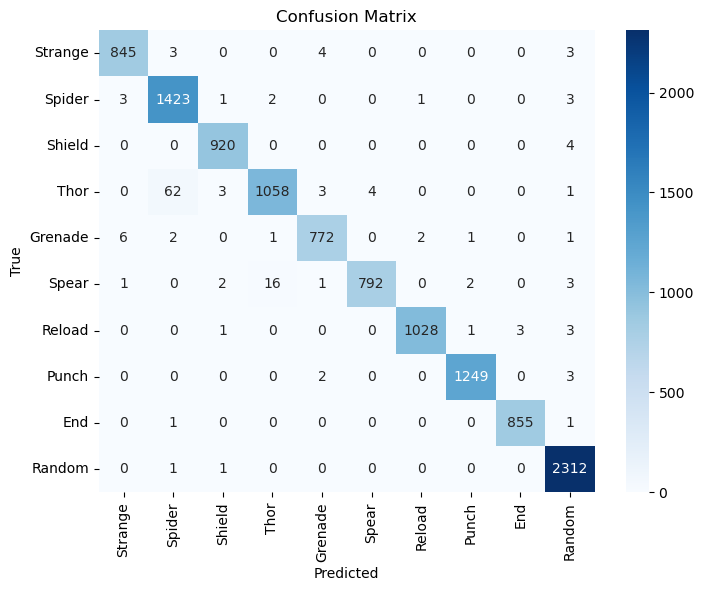

Accuracy: 98.67%
strange   0.9844357976653697
spider   0.962877030162413
shield   0.9866255144032922
thor   0.9603876949009692
grenade   0.9717037928958459
spear   0.9602305475504322
reload   0.9854413102820746
punch   0.9845107669059312
end   0.9834528405956977
random   0.9934600449621909


In [71]:
plot_confusion_matrix (y_train, X_train)

40/40 [==============================] - 0s 2ms/step


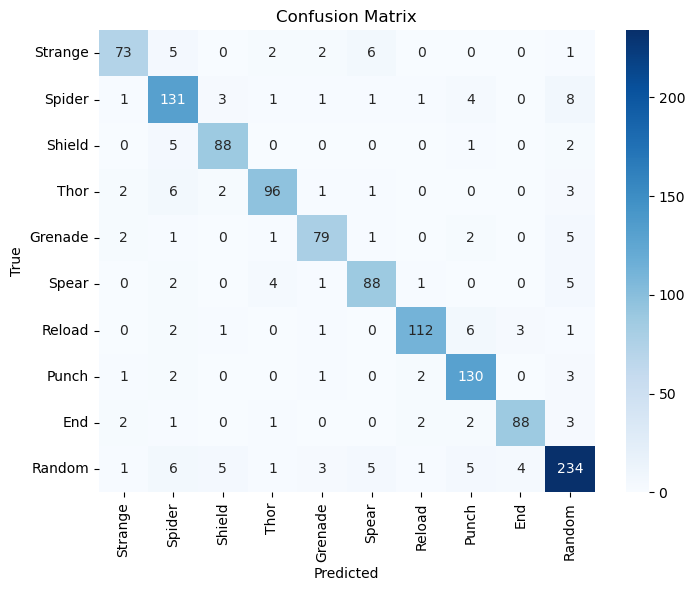

Accuracy: 88.25%
strange   0.9766949152542372
spider   0.9583333333333334
shield   0.9833333333333333
thor   0.9561191626409018
grenade   0.966324200913242
spear   0.9553376906318083
reload   0.9802065404475043
punch   0.9820531227566404
end   0.9785564853556485
random   0.9877859635517643


In [72]:
plot_confusion_matrix (y_val, X_val)

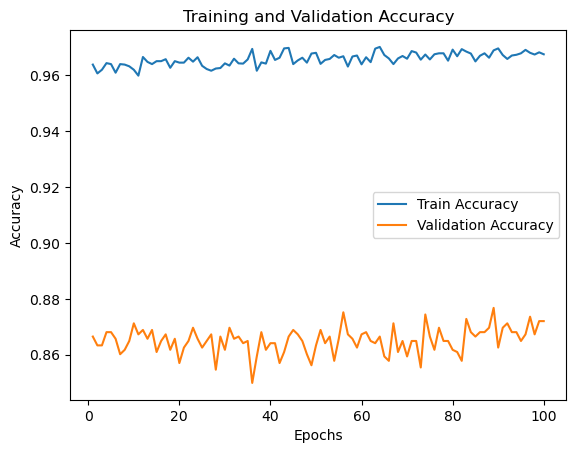

In [39]:
# Extract the training and validation accuracy from the history object
import matplotlib.pyplot as plt
train_accuracy = history_cnn.history['accuracy']
val_accuracy = history_cnn.history['val_accuracy']

# Plotting the accuracy
plt.plot(range(1, epochs+1), train_accuracy, label='Train Accuracy')
plt.plot(range(1, epochs+1), val_accuracy, label='Validation Accuracy')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Display the plot
plt.show()

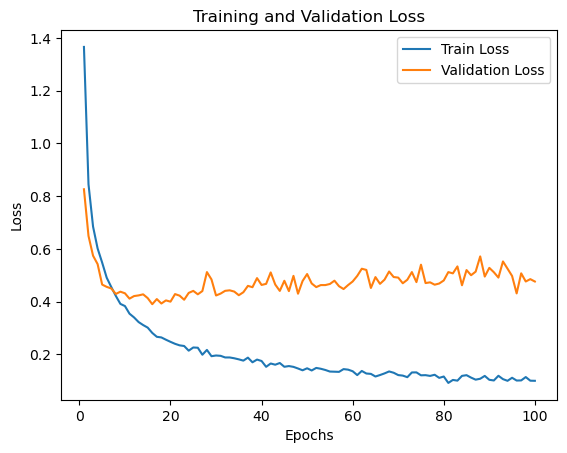

In [65]:
# Extract the training and validation accuracy from the history object
train_loss = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']

# Plotting the accuracy
plt.plot(range(1, epochs+1), train_loss, label='Train Loss')
plt.plot(range(1, epochs+1), val_loss, label='Validation Loss')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Display the plot
plt.show()

# Save Weights


In [73]:
from numpy import empty

def gen_conv_params(layer:Conv2D,
		label:str, kr:str, kc:str, f:str) -> str:
	'''
	Takes a Conv2D layer as input and returns a C initialization (as a
	string) of '(label)_weights[kr][kc][f]' and '(label)_biases[f]'
	arrays.
	'''

	w, b = layer.weights
	res = ''

	# Conversion of weights array.
	new_w = empty(shape=(w.shape[3],w.shape[0],w.shape[1]))
	for row in range(w.shape[0]):
		for col in range(w.shape[1]):
			for filter in range(w.shape[3]):
				new_w[filter][row][col] = w[row][col][0][filter]
	w = new_w

	# Weights: (label)_weights[kr][kc][f].
	res += '// ' + label.capitalize() + ' layer2 weights.\n'
	res += 'fixed_t ' + label + '_weights [' + f + '][' + kr + '][' \
			+ kc + ']\n\t= {\n'
	for filter in range(w.shape[0]):
		res += '\t\t\t{\n'
		for row in range(w.shape[1]):
			res += '\t\t\t\t{ '
			for col in range(w.shape[2]):
				res += f'{w[filter][row][col]}'
                
				if (col != w.shape[2]-1):
					res += ', '
				else:
					res += ' }'
			if(row != w.shape[1] -1):
				res += ','
			res += '\n'
		res += '\t\t\t}'
		if(filter != w.shape[0] -1):
			res += ','
		res += '\n'
	res +='\t\t};\n\n'

	# Biases: (label)_biases[f].
	res += '// ' + label.capitalize() + ' layer biases.\n'
	res += 'fixed_t ' + label + '_biases [' + f + '] = { '
	for i in range(b.shape[0]):
		res += str(float(b[i]))
		if (i != b.shape[0]-1):
			res += ', '
	res += ' };'

	return res

In [74]:
from numpy import empty

def gen_dense_params(layer:Dense,
		label:str, size0: str, size1: str) -> str:
    w, b = layer.weights
    w = np.transpose(w) 
    res = ""
    # Weights: (label)_weights[size0][size1].
    res += '// ' + label.capitalize() + ' layer weights.\n'
    res += 'fixed_t ' + label + '_weights[' + size0 + '][' + size1 + ']\n\t = {\n'
    for i in range(w.shape[0]):
        res += '\t\t\t{ '
        for j in range(w.shape[1]):
            res += str(float(w[i][j]))
            if j != w.shape[1] - 1:
                res += ', '
        res += ' }'
        if i != w.shape[0] - 1:
            res += ','
        res += '\n'
    res += '\t\t};\n\n'

     # Biases : (label)_biases[size1].
    res += '// ' + label.capitalize() + ' layer biases.\n'
    res += 'fixed_t ' + label + '_biases [' + size0 + '] = { '
    for i in range(b.shape[0]):
        res += str(float(b[i]))
        if (i != b.shape[0]-1):
            res += ', '
    res += ' };'

    return res

In [75]:
NUM_READINGS = 30
NUM_FEATURES = 14
NUM_CHANNELS = 1

DENSE_SIZE_1= 16
DENSE_SIZE_2 = 10

CONV_KERNEL_SIZE = 3
FILTERS = 16
CONV_STRIDE = 1

POOL_INPUT_ROWS = (NUM_READINGS - CONV_KERNEL_SIZE) / CONV_STRIDE + 1
POOL_INPUT_COLS = (NUM_FEATURES - CONV_KERNEL_SIZE) / CONV_STRIDE + 1 
POOL_KERNEL_SIZE = 3
POOL_STRIDE =  3

FLAT_INPUT_ROWS = (POOL_INPUT_ROWS - POOL_KERNEL_SIZE) / POOL_STRIDE + 1
FLAT_INPUT_COLS = (POOL_INPUT_COLS - POOL_KERNEL_SIZE) / POOL_STRIDE + 1
FLAT_SIZE = FLAT_INPUT_ROWS*FLAT_INPUT_COLS*FILTERS

In [77]:
filename = "conv2d_weights_15nov_3.h"
with open(filename, 'w') as file:
        file.write("#pragma once\n\n")
        file.write("#include \"definitions.h\"\n\n")
        conv_layer2 = gen_conv_params(model.get_layer(name='conv2d_3'), 'conv', 'CONV_KERNEL_ROW', 'CONV_KERNEL_COL', 'FILTERS')
        
        # Write the initializations to the file
        file.write(conv_layer2)
        file.write("\n")

In [79]:
filename = "dense_weights_15nov_3.h"
with open(filename, 'w') as file:
        file.write("#pragma once\n\n")
        file.write("#include \"definitions.h\"\n")
        
        dense_1 = gen_dense_params(model.get_layer(name='dense_9'), 'dense1', 'DENSE_SIZE1', 'DENSE_INPUT_SIZE')
        dense_2 = gen_dense_params(model.get_layer(name='dense_10'), 'dense2', 'DENSE_SIZE2', 'DENSE_SIZE1')
        dense_3 = gen_dense_params(model.get_layer(name='dense_11'), 'dense3', 'NUM_CLASSES', 'DENSE_SIZE2')

        file.write(dense_1)   
        file.write(dense_2)
        file.write(dense_3)

        file.write("\n")  